In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [ ]:
df = pd.read_csv("../Data/final_engineered_features.csv")
df = df[df['Product Type'] == 'Food/Cosmetics'] #filtering for food products

# Keep only companies with at least one recall
# company_with_recall = df.groupby("Legal Name")['recalled_bool'].sum()
# companies_to_keep = company_with_recall[company_with_recall > 0].index
# df = df[df['Legal Name'].isin(companies_to_keep)].copy()

# Frequency encode 'City'
# city_freq_map = df['City'].value_counts().to_dict()
# df['City_freq'] = df['City'].map(city_freq_map)

# Drop non-relevant columns
df = df.drop(['classification_flag','Legal Name','City','Zip','FEI Number','Additional Details','FMD-145 Date','Inspection ID','Inspection End Date'], axis=1) 

# One-hot encoding categorical variables
categorical_cols = ['Classification', 'Project Area', 'Product Type', 'State', 'Country/Area', 'inspection_season'] 
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int) 
df['Posted Citations'] = df['Posted Citations'].notnull().astype(int) #converting Posted Citations to binary



# row count
print(f"Row count: {df.shape[0]}", 'recall bool 0:', df['recalled_bool'].value_counts()[0], 'recall bool 1:', df['recalled_bool'].value_counts()[1])

# random rows
df.sample(5)

/var/folders/nt/9z_y1zvs4fv44k33p7cff_cc0000gp/T/ipykernel_66217/775872324.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/final_engineered_features.csv")


Row count: 173494 recall bool 0: 158176 recall bool 1: 15318


,Fiscal Year,Posted Citations,recalled_bool,inspection_year,inspection_month,inspection_dayofweek,inspection_quarter,week_of_year,days_since_last_inspection,City_freq,Classification_Official Action Indicated (OAI),Classification_Voluntary Action Indicated (VAI),Project Area_Colors and Cosmetics Technology,"Project Area_Food Composition, Standards, Labeling and Econ",Project Area_Food and Color Additives Petition Review,Project Area_Foodborne Biological Hazards,Project Area_Molecular Biology and Natural Toxins,Project Area_Pesticides and Chemical Contaminants,Project Area_Technical Assistance: Food and Cosmetics,State_Alabama,State_Alaska,State_American Samoa,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Guam,State_Hawaii,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Northern Mariana Islands,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Puerto Rico,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virgin Islands,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Country/Area_Argentina,Country/Area_Armenia,Country/Area_Australia,Country/Area_Austria,Country/Area_Bahamas,Country/Area_Bahrain,Country/Area_Bangladesh,Country/Area_Barbados,Country/Area_Belarus,Country/Area_Belgium,Country/Area_Belize,Country/Area_Benin,Country/Area_Bolivia,Country/Area_Bosnia-Hercegovina,Country/Area_Brazil,Country/Area_Bulgaria,Country/Area_Burma (Myanmar),Country/Area_Cambodia,Country/Area_Canada,Country/Area_Cape Verde,Country/Area_Chile,Country/Area_China,Country/Area_Colombia,Country/Area_Costa Rica,Country/Area_Croatia,Country/Area_Cyprus,Country/Area_Czech Republic,Country/Area_Denmark,Country/Area_Dominican Republic (the),Country/Area_Ecuador,Country/Area_Egypt,Country/Area_El Salvador,Country/Area_Estonia,Country/Area_Faroe Islands,Country/Area_Fiji,Country/Area_Finland,Country/Area_France,Country/Area_French Polynesia,Country/Area_Georgia,Country/Area_Germany,Country/Area_Ghana,Country/Area_Gibraltar,Country/Area_Greece,Country/Area_Greenland,Country/Area_Grenada,Country/Area_Guatemala,Country/Area_Guyana,Country/Area_Honduras,Country/Area_Hong Kong SAR,Country/Area_Hungary,Country/Area_Iceland,Country/Area_India,Country/Area_Indonesia,Country/Area_Ireland,Country/Area_Israel,Country/Area_Italy,Country/Area_Ivory Coast,Country/Area_Jamaica,Country/Area_Japan,Country/Area_Jordan,Country/Area_Kazakhstan,Country/Area_Kenya,Country/Area_Korea (the Republic of),Country/Area_Latvia,Country/Area_Lesotho,Country/Area_Lithuania,Country/Area_Macao,Country/Area_Macedonia,Country/Area_Madagascar,Country/Area_Malawi,Country/Area_Malaysia,Country/Area_Maldives,Country/Area_Malta,Country/Area_Marshall Islands,Country/Area_Mauritius,Country/Area_Mexico,Country/Area_Moldova,Country/Area_Morocco,Country/Area_Mozambique,Country/Area_Namibia,Country/Area_Netherlands,Country/Area_New Zealand,Country/Area_Nicaragua,Country/Area_Nigeria,Country/Area_Norway,Country/Area_Oman,Country/Area_Panama,Country/Area_Paraguay,Country/Area_Peru,Country/Area_Philippines,Country/Area_Poland,Country/Area_Portugal,Country/Area_Romania,Country/Area_Russia,Country/Area_Saint Lucia,Country/Area_Senegal,Country/Area_Serbia,Country/Area_Seychelles,Country/Area_Singapore,Country/Area_Slovakia,Country/Area_Slovenia,Country/Area_South Africa,Country/Area_Spain,Country/Area_Sri Lanka,Country/Area_St. Vincent & The Grenadines,Country/Area_Suriname,Country/Area_Swaziland,Country/Area_Sweden,Country/Area_Switzerland,Country/Area_Taiwan,Country/Area_Thailan

In [3]:
X = df.drop(['recalled_bool'], axis=1)
y = df['recalled_bool']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

Code for comparing pre tuned naive models using cross validation

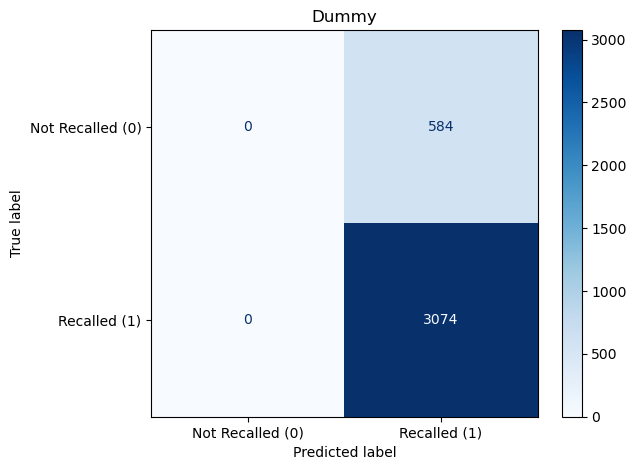

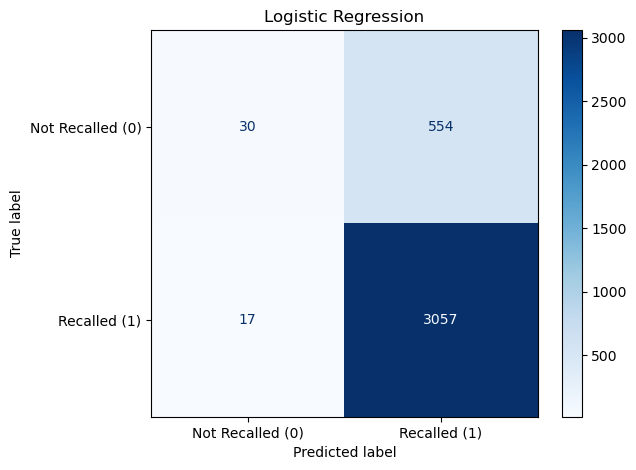

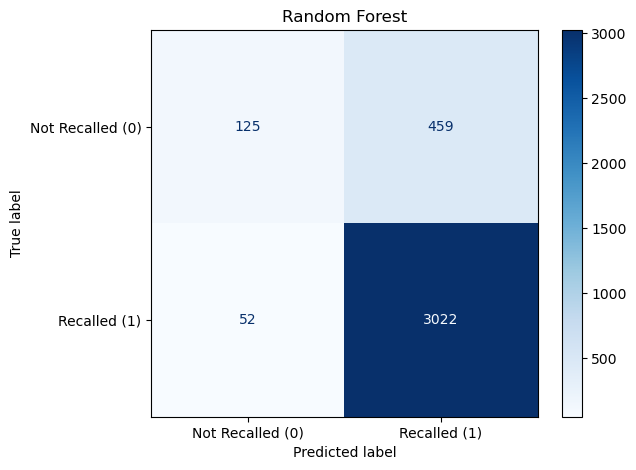

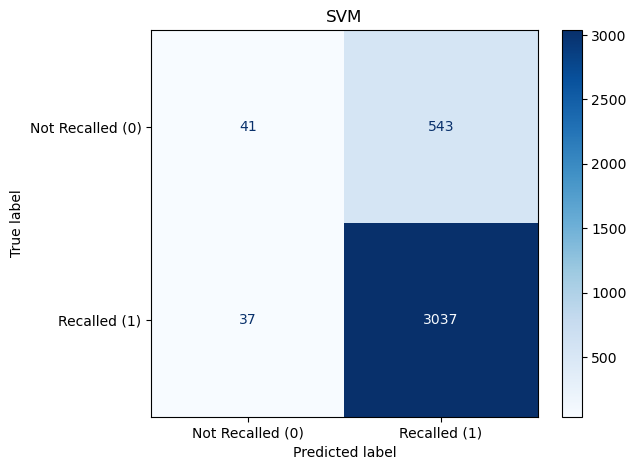


Cross-validation results:
                     F1 Score (No Recall)  F1 Score (Recall)  Accuracy  \
Dummy                            0.000000           0.913250  0.840350   
Logistic Regression              0.095087           0.914585  0.843904   
Random Forest                    0.328515           0.922044  0.860306   
SVM                              0.123867           0.912834  0.841443   

                     Precision (No Recall)  Precision (Recall)  
Dummy                             0.000000            1.000000  
Logistic Regression               0.051370            0.994470  
Random Forest                     0.214041            0.983084  
SVM                               0.070205            0.987964  


In [6]:
# Using pipelines for scaling and model fitting
models = {
    'Dummy': Pipeline([('scaler', StandardScaler()), ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))]),

    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='liblinear', random_state=42))]),

    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))]),
    
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC(kernel='linear', random_state=42))])
}


# results will hold the cross validation results
results1 = np.zeros((4, 5))

# Train and evaluate each model
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    results1[i, 0] = report['0']['f1-score']
    results1[i, 1] = report['1']['f1-score']
    results1[i, 2] = report['accuracy']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results1[i, 3] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    results1[i, 4] = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recalled (0)', 'Recalled (1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.tight_layout()
    plt.show()

# Use results to create a DataFrame for better visualization
results1_df = pd.DataFrame(results1, columns=['F1 Score (No Recall)', 'F1 Score (Recall)', 'Accuracy', 'Precision (No Recall)', 'Precision (Recall)'],
                            index=models.keys())
print("\nCross-validation results:")
pd.set_option('display.max_columns', None)
print(results1_df)

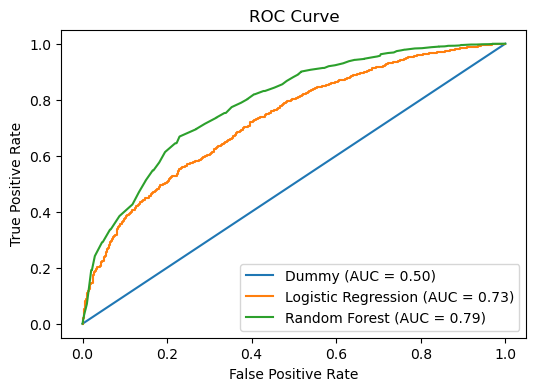

In [40]:
# For each model, plot ROC curve in the same figure and calculate AUC
plt.figure(figsize=(6, 4))

for i, (name, model) in enumerate(models.items()):
    if name != 'SVM':  # SVM does not support predict_proba 

        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Code for final model (tuned) selection using cross validation
1. hyperparameter tuning for Random Forest and SVM done using GridSearchCV in their respective notebooks
2. class weight is balanced since the data is imbalanced, leaning toward not recalled

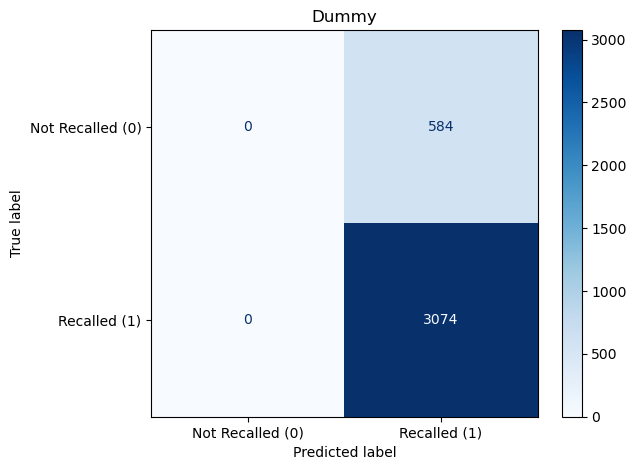

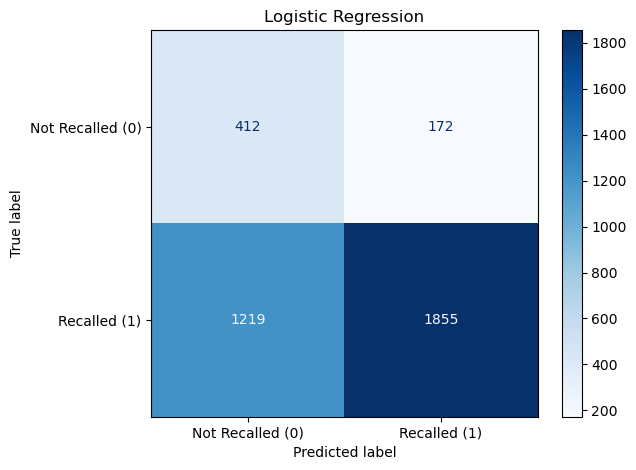

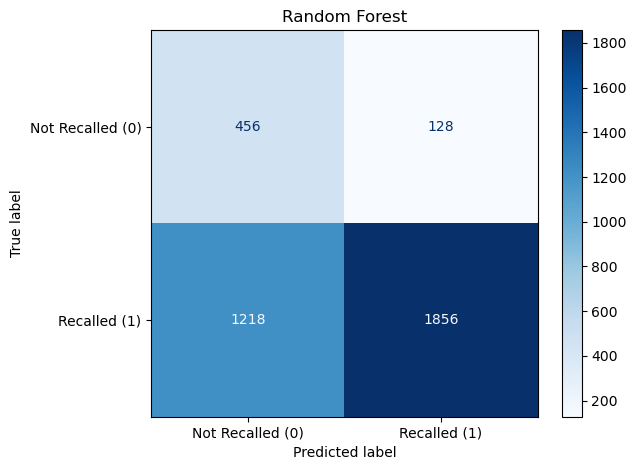

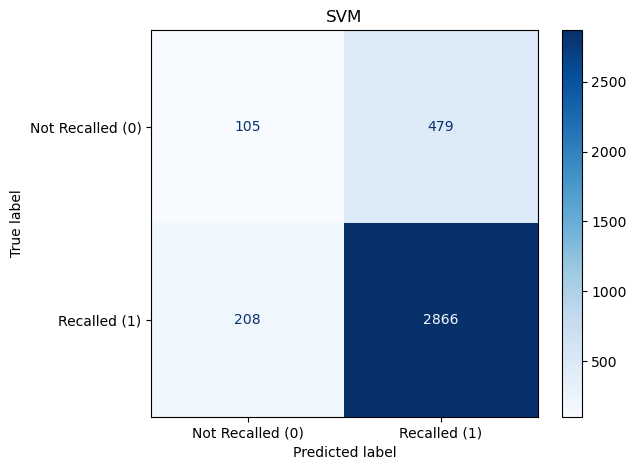


Cross-validation results:
                     F1 Score (No Recall)  F1 Score (Recall)  Accuracy  \
Dummy                            0.000000           0.913250  0.840350   
Logistic Regression              0.372009           0.727308  0.619738   
Random Forest                    0.403897           0.733887  0.632039   
SVM                              0.234114           0.892974  0.812192   

                     Precision (No Recall)  Precision (Recall)  
Dummy                             0.000000            1.000000  
Logistic Regression               0.705479            0.603448  
Random Forest                     0.780822            0.603774  
SVM                               0.179795            0.932336  


In [7]:
# Using pipelines for scaling and model fitting
models = {
    'Dummy': Pipeline([('scaler', StandardScaler()), ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))]),

    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))]),

    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42))]),
    
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC(C=100, class_weight='balanced', gamma=1, kernel='rbf', random_state=42))])
}


# results will hold the cross validation results
results2 = np.zeros((4, 5))

# Train and evaluate each model
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    results2[i, 0] = report['0']['f1-score']
    results2[i, 1] = report['1']['f1-score']
    results2[i, 2] = report['accuracy']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results2[i, 3] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    results2[i, 4] = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recalled (0)', 'Recalled (1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.tight_layout()
    plt.show()


# Use results to create a DataFrame for better visualization
results2_df = pd.DataFrame(results2, columns=['F1 Score (No Recall)', 'F1 Score (Recall)', 'Accuracy', 'Precision (No Recall)', 'Precision (Recall)'],
                            index=models.keys())
print("\nCross-validation results:")
pd.set_option('display.max_columns', None)
print(results2_df)

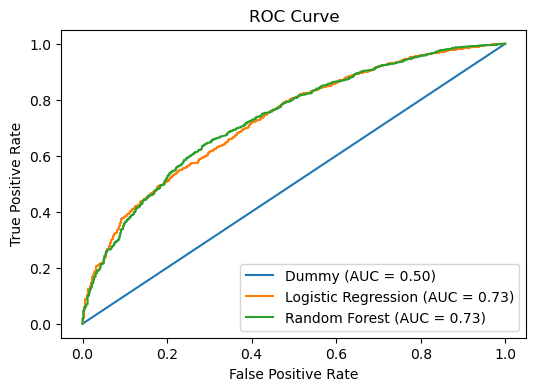

In [42]:
# For each model, plot ROC curve in the same figure and calculate AUC
plt.figure(figsize=(6, 4))

for i, (name, model) in enumerate(models.items()):
    if name != 'SVM':  # SVM does not support predict_proba 

        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()